# Decision Tree Iris Dataset Example

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from xgboost.sklearn import XGBClassifier
from scipy.stats import uniform, truncnorm, randint
from itertools import compress

from pprint import pprint

import pandas as pd
import numpy as np

from dtreeviz.trees import dtreeviz
import matplotlib.pyplot as plt
%matplotlib inline

The data are from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality).
<br>
<br>
They contain information about chemical and sensory characteristics of wines as well as a rating of the quality of the wine.
<br>
<br>
I'm only going to use this dataset to provide an example of how to construct a randomized search to tune hyperparameters using sci-kit learn's `Pipeline` function. There is much more you could do with this dataset, and if you were actually going to construct a proper model you'd want to do EDA, data cleaning, and do some class balancing of course!

##### Read in the data

In [ ]:
## red and white wine are stored in separate csvs
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')
## concatenate into single df
wines = pd.concat([red_wine,white_wine])
## look at data
wines.head()

The class label column is the quality' column. It's currently an ordinal multiclass label (quality rating between 0-10 with 0 being worst 10 being best). For simplicity I'm just going to turn this into a binary class label with all values less than or equal to five categorized as 'bad' quality and anything with a rating higher than five as 'good' quality. 

In [ ]:
## create new binary class labels
wines['quality_category'] = np.where(wines.quality<=5, 'bad', 'good')
## drop the old labels
wines.drop(['quality'], axis=1, inplace=True)

##### Train-test split

In [ ]:
## features
X = wines.iloc[:,:-1]
## label
y = wines.quality_category
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Begin Pipeline

Basic pipeline steps with hyperparameter tuning are:<br>
<br>
1) define the models to fit

2) define the hyperparameters to search over for each model

3) put together using the `Pipeline` function

4) compare results of all fitted models with tuned hyperparameters

##### 1) Define models

Since we are talking about decision trees, random forests, and XGBoost today we will fit these three models

In [ ]:
## define the models to fit
base_models = [DecisionTreeClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               XGBClassifier(random_state=42)]

##### 2) Define the hyperparameters

As you know, each model has many hyperparameters you can tune. There are also a couple of options for how to tune the hyperparameters - grid search and randomized search.
<br>
<br>
With grid search, the user specifically defines which values the hyperparameters will take, with random search, the user defines a random distribution for the search to pass over and the user can define what distribution the hyperparameters should take. 
<br>
<br>
In order to feed the parameters into the pipeline, they need to have the model name as a prefix before the hyperparameter name, separated by a dunder (e.g. `clf__criterion`)
<br>
<br>
If you don't remember what hyperparameters a model has a quick way to check is `get_params`

In [12]:
## check hyperparameters of a model
list(DecisionTreeClassifier().get_params().keys())

['ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'presort',
 'random_state',
 'splitter']

In [ ]:
# define models to test:
check_params_dtree = {'clf__criterion':['gini', 'entropy'],
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(1,10)}

check_params_rf = {'clf__criterion':['gini', 'entropy'],
                   'clf__n_estimators': randint(4,200),
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(3,15)}

check_params_xgb = {'clf__max_depth':randint(3,15),
                    'clf__n_estimators':randint(4,200),
                    'clf__learning_rate':uniform(0.01,0.199)
                   }

## save parameter spaces in a list
check_params = [check_params_dtree, check_params_rf, check_params_xgb]

##### 3) Put together in the pipeline function

The pipeline function can have many more steps than what is presented here. Each step should be given a name (e.g. `('sc1', StandardScaler())`). You can put all sorts of stuff in the pipeline, but here I just put the scaling function because it was simple and all of the datasets features are numeric. I don't know if the data actually need this part or if this is the best scaling factor to fit but it's just an example. 

In [ ]:
def modelFit(clf, params, X_train, y_train, X_test, y_test):
    """A model to fit the pipeline for a predefined model (clf) using a randomized search
    cross validation to tune the hyperparameters (params:dict of predefined hyperparams to search).
    Returns the model and a classification report of the model"""
    
    pipe = Pipeline(steps=[('sc1', StandardScaler()),
                          ('clf', clf)])
    
    random_search = RandomizedSearchCV(pipe,
                                      params,
                                      n_iter=100,
                                      cv=5,
                                      random_state=42)
    
    model_out = random_search.fit(X_train, y_train)
    
    y_true, y_pred = y_test, model_out.predict(X_test)
    
    classification_rep = classification_report(y_true, y_pred)
    
    return model_out, classification_rep

##### 4) Fit and compare the models

Now we can put it all together and compare our models with the tuned hyperparameters using the classification reports for each model.

In [193]:
### empty spaces to save the models and classification reports
fitted_models = []
classification_reps = []

## run the model for each respective pair of models and hyperparameter dicts
for mod, param in zip(base_models, check_params):
    one_mod, one_classification = modelFit(mod, param, X_train, y_train, X_test, y_test)
    fitted_models.append(one_mod)
    classification_reps.append(one_classification)

## print the classification reports    
[print(x) for x in classification_reps]

From the classification report you can see that the, based on the F1 score, the XGBoost model fits the best. However, remember that we didn't clean or balance these data...so, don't draw any conclusions from this!

## Decision Tree Visualization Examples
<br>

### For funsies

<br>
If your data has a lot of features, especially a lot of numeric features, it can be too unweildly to visualize a tree. But if your n features is relatively small you can make a neat visualization.
<br>
<br>
The wine dataset is a little much for this visualization, but the comparitively simple iris dataset provides a nice example

In [4]:
# load data and split into x, y
iris = load_iris()
X = iris.data
y = iris.target

# Fit the classifier with default hyper-parameters just to do this simply and quickly
clf = DecisionTreeClassifier(random_state=42)
model = clf.fit(X, y)

One visualization for decision trees is available as the `plot_tree` function in sci-kit learn. It shows all the leaves and nodes of a fitted tree and prints the split criteria (e.g. petal length <= 4.85), the number of samples available for the split and the the gini index of the leaf (or entropy depending on how you set up your model). 

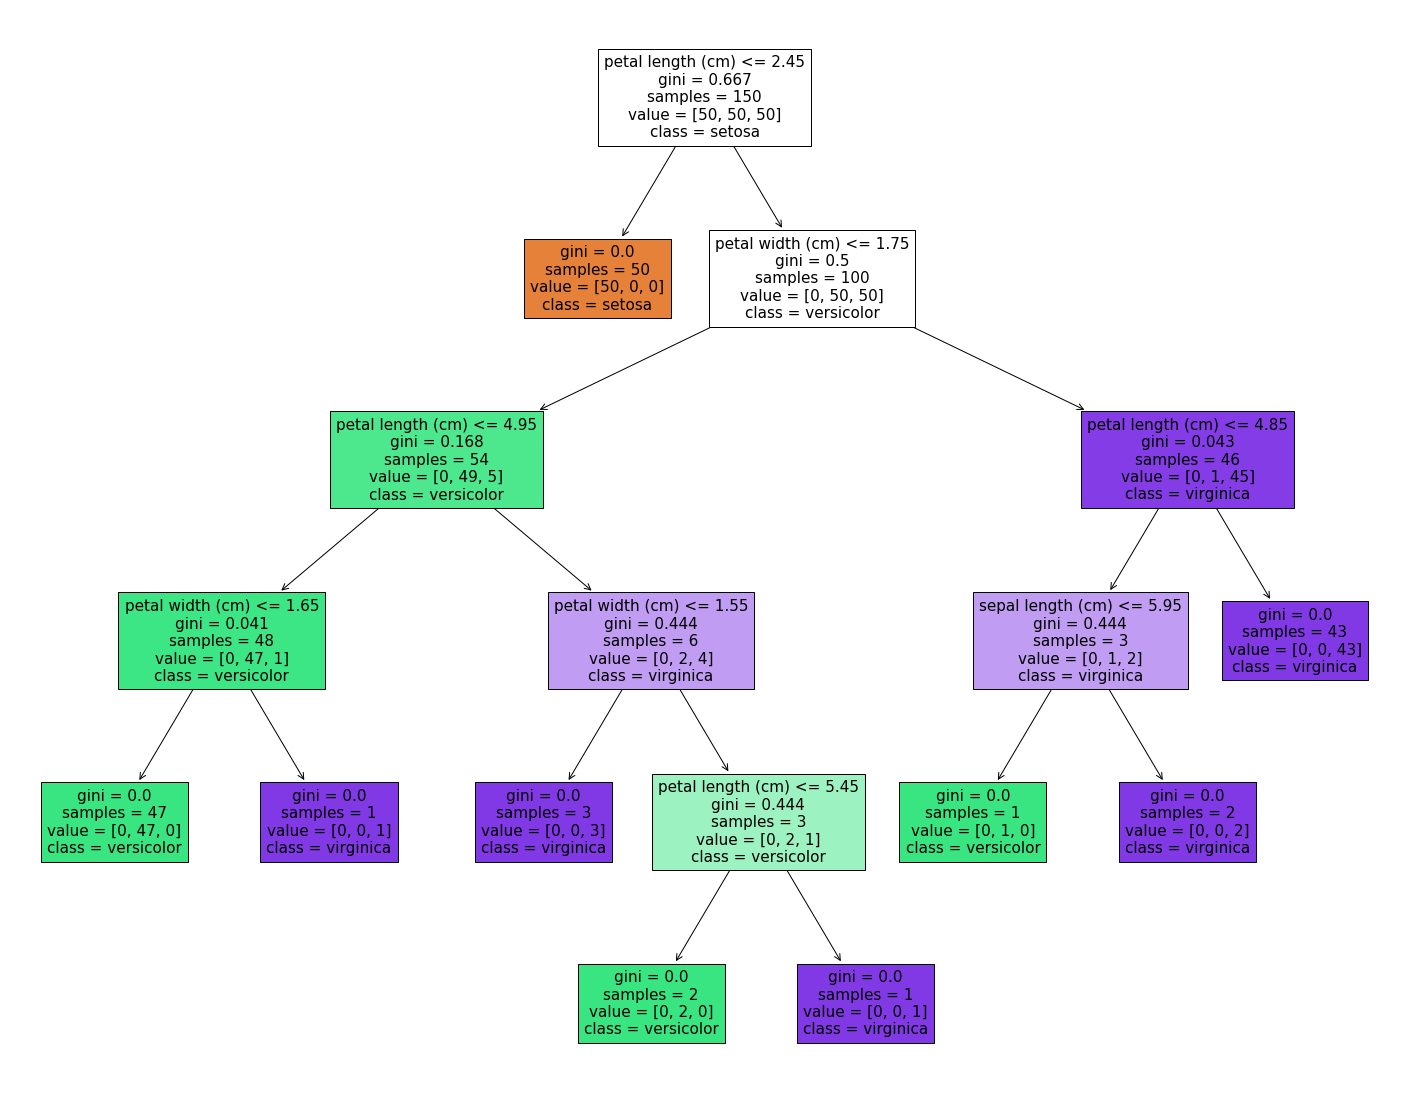

In [6]:
## set plotting area
fig = plt.figure(figsize=(25,20))

## plot the fitted tree
vis_tree = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

Another cool way to visualize a tree is using the dtreeviz package (installation instructions [here](https://github.com/parrt/dtreeviz) -- the graphviz dependency can be iffy so follow their installation instructions carefully). The dtreeviz shows the distribution of samples within each class for each split as well as the split criteria and the number of samples in each terminal leaf. 

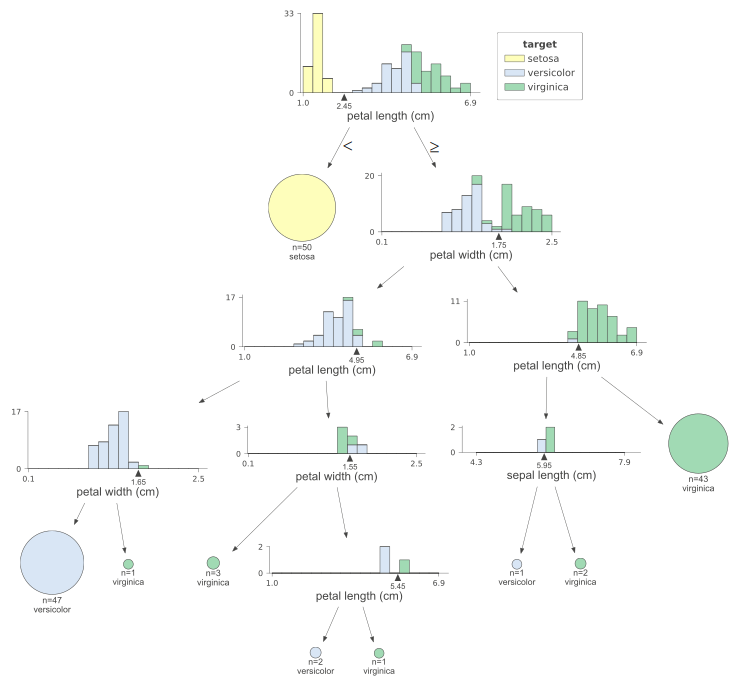

In [5]:
viz = dtreeviz(clf, X, y,
                target_name="target",
                feature_names=iris.feature_names,
                class_names=list(iris.target_names),
                scale = 1.3)
viz

I hope any of this code comes in useful to you in the future!

Here are some useful blogs and links I referenced when making this notebook

- [the dtreeviz git](https://github.com/parrt/dtreeviz)
- [dtreeviz examples in colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/examples.ipynb#scrollTo=KTpQ2_t-WLZr)
- [4 ways to visualize a tree](https://mljar.com/blog/visualize-decision-tree/)
- [blog on randomized parameter search](https://jamesrledoux.com/code/randomized_parameter_search)
- [sci-kit learn doc on Pipeline with good examples](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)
- [hyperparameter tuning with pipelines](https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6)
- [this short but sweet kaggle notebook on xgboost](https://www.kaggle.com/justindeed/iris-with-xgboost-and-gridsearchcv)
- [math behind decision trees explained with an example](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93)